In [1]:
import numpy as np
import importlib, os, datetime, pickle
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML, Image
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
from quick_sim import setup_sim


# import edward_tools.fq_runner as fq_runner
from edward_tools.cfqp_3D_potential import coupled_flux_qubit_3D_non_linear_approx_pot, coupled_flux_qubit_3D_non_linear_approx_force
from edward_tools.visualization import animate_sim_flux_qubit, plotFidelityBarChart, separate_by_state_2
from edward_tools.initial_state_sampling import extra_constraint_00_and_11_only
from NAND_PARAMETERS import *
import importlib

import kyle_tools as kt
import matplotlib.pyplot as plt

from edward_tools import cfq_3D_runner, coupled_fq_protocol_library

import edward_tools.cfq_batch_sweep as cfq_batch_sweep
import edward_tools.Analysis_tool.general_analysis_tools as general_analysis_tool
# from edward_tools.Analysis_tool.general_analysis_tools import show_phi_dc_with_time
import edward_tools.Analysis_tool.minimum_value_of_potential as minimum_value_of_potential
from edward_tools.couple_flux_qubit_metrics import fidelityEvaluation

In [80]:
def get_XYU(domain = [-4, 4], resolution = 50, detail_info = False, params = initial_parameter_dict):
    """
    To get the 2D data of the potential for contour plots
    """
    x_vec = np.linspace(domain[0], domain[1], resolution)

    phi_1xdc, phi_2xdc, phi_3xdc = params['phi_1xdc'], params['phi_2xdc'], params['phi_3xdc']
    X, Y = np.meshgrid(x_vec, x_vec)
    U_12 = coupled_fq_pot.potential(X, Y, 0, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_23 = coupled_fq_pot.potential(0, X, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_13 = coupled_fq_pot.potential(X, 0, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    return X, Y, U_12, U_23, U_13

def get_XYU_6_plane(domain = [-4, 4], resolution = 50, detail_info = False, params = initial_parameter_dict):
    """
    To get the 2D data of the potential for contour plots
    """
    x_vec = np.linspace(domain[0], domain[1], resolution)

    phi_1xdc, phi_2xdc, phi_3xdc = params['phi_1xdc'], params['phi_2xdc'], params['phi_3xdc']
    X, Y = np.meshgrid(x_vec, x_vec)
    U_12_top = coupled_fq_pot.potential(X, Y, 2.043, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_12_bottom = coupled_fq_pot.potential(X, Y, -2.043, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_23_right = coupled_fq_pot.potential(2.043, X, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_23_left = coupled_fq_pot.potential(-2.043, X, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_13_front = coupled_fq_pot.potential(X, 2.043, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_13_back = coupled_fq_pot.potential(X, -2.043, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    return X, Y, U_12_top, U_12_bottom, U_23_left, U_23_right, U_13_front, U_13_back

In [2]:
default_potential_params = [1, 1, 1, 20, 20, 20, 2.3, 2.3, 2.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [312]:
PHI_0 = 2.067833848 * 1e-15
k_B = 1.38e-23
T = 0.5
k_BT = k_B * T

C_factor = 1
L_factor = 1
R_factor = 20
I_m_factor = 0

U0_1, U0_2, U0_3 = 1, 1, 1

I_p_1, I_p_2, I_p_3 = 5e-6, 5e-6 , 5e-6  # Amp
I_m_1, I_m_2, I_m_3 = 7e-9 * I_m_factor, 7e-9 * I_m_factor, 7e-9 * I_m_factor              # Amp
R_1, R_2, R_3 = 1 * R_factor, 1 * R_factor, 1 * R_factor           # ohm
C_1, C_2, C_3 = 500e-15 * C_factor, 500e-15 * C_factor, 500e-15 * C_factor                 # F
L_1, L_2, L_3 = 140e-12 * L_factor, 140e-12 * L_factor, 140e-12 * L_factor                 # H  

x_c = PHI_0 / (2 * np.pi)
t_c = np.sqrt(L_1 * C_1)
v_c = x_c / t_c
gamma_1, gamma_2, gamma_3 = 20, 20, 20


beta_1 = 2 * np.pi * L_1 * I_p_1 / PHI_0; 
beta_2 = 2 * np.pi * L_2 * I_p_2 / PHI_0;
beta_3 = 2 * np.pi * L_3 * I_p_3 / PHI_0;

beta_1 = 2.3
beta_2 = 2.3
beta_3 = 2.3

d_beta_1 = 2 * np.pi * L_1 * I_m_1 / PHI_0; 
d_beta_2 = 2 * np.pi * L_2 * I_m_2 / PHI_0;
d_beta_3 = 2 * np.pi * L_3 * I_m_3 / PHI_0;

In [11]:
initial_parameter_dict = {
    "U0_1": U0_1, "U0_2": U0_2, "U0_3": U0_2, "gamma_1": gamma_1, "gamma_2": gamma_2, "gamma_3": gamma_3, 
    "beta_1": beta_1, "beta_2": beta_2, "beta_3": beta_3, "d_beta_1": d_beta_1, "d_beta_2": d_beta_2, "d_beta_3": d_beta_3, "phi_1x": 0, "phi_2x": 0, "phi_3x": 0, "phi_1xdc": 0, "phi_2xdc": 0, "phi_3xdc": 0, "mu_12":0, "mu_13": 0, "mu_23": 0
}

In [12]:
"""
# step 1: Define potential
"""
coupled_fq_default_param = [1, 1, 1, 20, 20, 20, 2.3, 2.3, 2.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[phi_1_bound, phi_2_bound, phi_3_bound, phi_1dc_bound, phi_2dc_bound, phi_3dc_bound] = np.array([4, 4, 4, 4, 4, 4])
contour_range = [300, 2000]
    
coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_3_bound, -phi_1dc_bound, -phi_2dc_bound, -phi_3dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_3_bound, phi_1dc_bound, phi_2dc_bound, phi_3dc_bound]]

# coupled_fq_pot = Potential(coupled_flux_qubit_pot_with_offset_at_00_xy, coupled_flux_qubit_force, 14, 4,\
#                            default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)

coupled_fq_pot = Potential(coupled_flux_qubit_3D_non_linear_approx_pot, coupled_flux_qubit_3D_non_linear_approx_force, 21, 6,\
                           default_params = initial_parameter_dict,  relevant_domain = coupled_fq_domain)


In [14]:
phi_1, phi_2 = np.linspace(-4, 4, 1000), np.linspace(-4, 4, 1000)

[None, None, None]

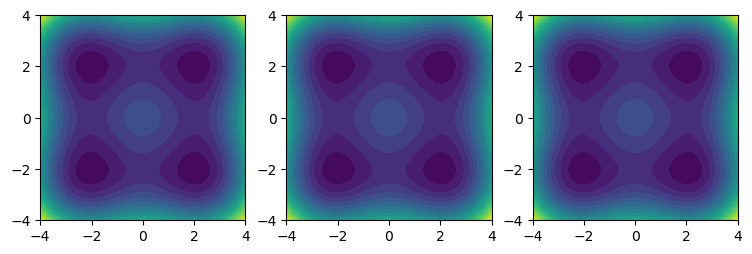

In [79]:
parameter_dict = {
    "U0_1": U0_1, "U0_2": U0_2, "U0_3": U0_2, "gamma_1": gamma_1, "gamma_2": gamma_2, "gamma_3": gamma_3, 
    "beta_1": beta_1, "beta_2": beta_2, "beta_3": beta_3, "d_beta_1": d_beta_1, "d_beta_2": d_beta_2, "d_beta_3": d_beta_3, 
    "phi_1x": 0.0, "phi_2x": 0.0, "phi_3x": 0.0, "phi_1xdc": 0.0, "phi_2xdc": 1.7, "phi_3xdc": 0, 
    "mu_12":0.0, "mu_13": 0.0, "mu_23": 0.3
}

X, Y, U_12, U_23, U_13 = get_XYU(params = parameter_dict)
fig, ax = plt.subplots(1, 3, figsize = [9, 3])
contour_level = 20
contour_plot_12 = ax[0].contourf(X, Y, U_12, contour_level)
contour_plot_23 = ax[1].contourf(X, Y, U_23, contour_level)
contour_plot_13 = ax[2].contourf(X, Y, U_13, contour_level)
[ax[i].set_aspect(1) for i in range(0, 3)]
# ax[0].set_title("phi_1, phi_2 plane")
# ax[1].set_title("phi_2, phi_3 plane")
# ax[2].set_title("phi_1, phi_3 plane")

# six plane potential

[None, None, None]

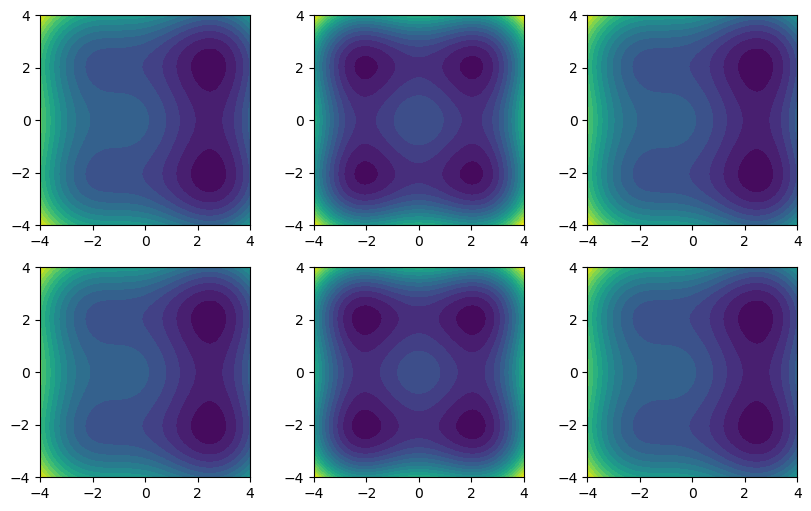

In [90]:
parameter_dict = {
    "U0_1": U0_1, "U0_2": U0_2, "U0_3": U0_2, "gamma_1": gamma_1, "gamma_2": gamma_2, "gamma_3": gamma_3, 
    "beta_1": beta_1, "beta_2": beta_2, "beta_3": beta_3, "d_beta_1": d_beta_1, "d_beta_2": d_beta_2, "d_beta_3": d_beta_3, 
    "phi_1x": 1.0, "phi_2x": 0.0, "phi_3x": 0.0, "phi_1xdc": 0.0, "phi_2xdc": 0, "phi_3xdc": 0, 
    "mu_12":0.0, "mu_13": 0.0, "mu_23": 0.0
}


X, Y, U_12_top, U_12_bottom, U_23_left, U_23_right, U_13_front, U_13_back = get_XYU_6_plane(params = parameter_dict)
fig, ax = plt.subplots(2, 3, figsize = [10, 6])
contour_level = 20
contour_plot_12_top = ax[0][0].contourf(X, Y, U_12_top, contour_level)
contour_plot_12_bottom = ax[1][0].contourf(X, Y, U_12_bottom, contour_level)
contour_plot_23_right = ax[0][1].contourf(X, Y, U_23_right, contour_level)
contour_plot_23_left = ax[1][1].contourf(X, Y, U_23_left, contour_level)
contour_plot_13_front = ax[0][2].contourf(X, Y, U_13_front, contour_level)
contour_plot_13_back = ax[1][2].contourf(X, Y, U_13_back, contour_level)
[ax[0][i].set_aspect(1) for i in range(0, 3)]
[ax[1][i].set_aspect(1) for i in range(0, 3)]

In [91]:
def LHS_function(phi_1, phi_2, phi_3, params):
    phi_1x, phi_2x, phi_3x = params['phi_1x'], params['phi_2x'], params['phi_3x']
    mu_12, mu_13, mu_23 = params['mu_12'], params['mu_13'], params['mu_23']
    return (phi_1 - phi_1x) + (mu_12 + mu_13 * mu_12) * (phi_2 - phi_2x) + (mu_13 + mu_12 * mu_12) * (phi_3 - phi_3x)

def RHS_function(phi_1, beta):
    return beta * np.sin(phi_1)

In [110]:
def draw_dUdp1_on_edges(test_params):
    phi_1_array = np.linspace(-3, 3, 1000)
    beta_p = 2.3 * np.cos(test_params['phi_1xdc'])
    fig, ax = plt.subplots(2, 2, figsize = [10, 10])
    LHS_11 = [LHS_function(_phi_1, 2, 2, test_params) for _phi_1 in phi_1_array]
    RHS = [RHS_function(_phi_1, beta_p) for _phi_1 in phi_1_array]
    ax[0][0].plot(phi_1_array, LHS_11)
    ax[0][0].plot(phi_1_array, RHS)
    
    LHS_01 = [LHS_function(_phi_1, -2, 2, test_params) for _phi_1 in phi_1_array]
    ax[0][1].plot(phi_1_array, LHS_01)
    ax[0][1].plot(phi_1_array, RHS)
    
    LHS_10 = [LHS_function(_phi_1, 2, -2, test_params) for _phi_1 in phi_1_array]
    RHS = [RHS_function(_phi_1, beta_p) for _phi_1 in phi_1_array]
    ax[1][0].plot(phi_1_array, LHS_10)
    ax[1][0].plot(phi_1_array, RHS)
    
    LHS_00 = [LHS_function(_phi_1, -2, -2, test_params) for _phi_1 in phi_1_array]
    ax[1][1].plot(phi_1_array, LHS_00)
    ax[1][1].plot(phi_1_array, RHS)

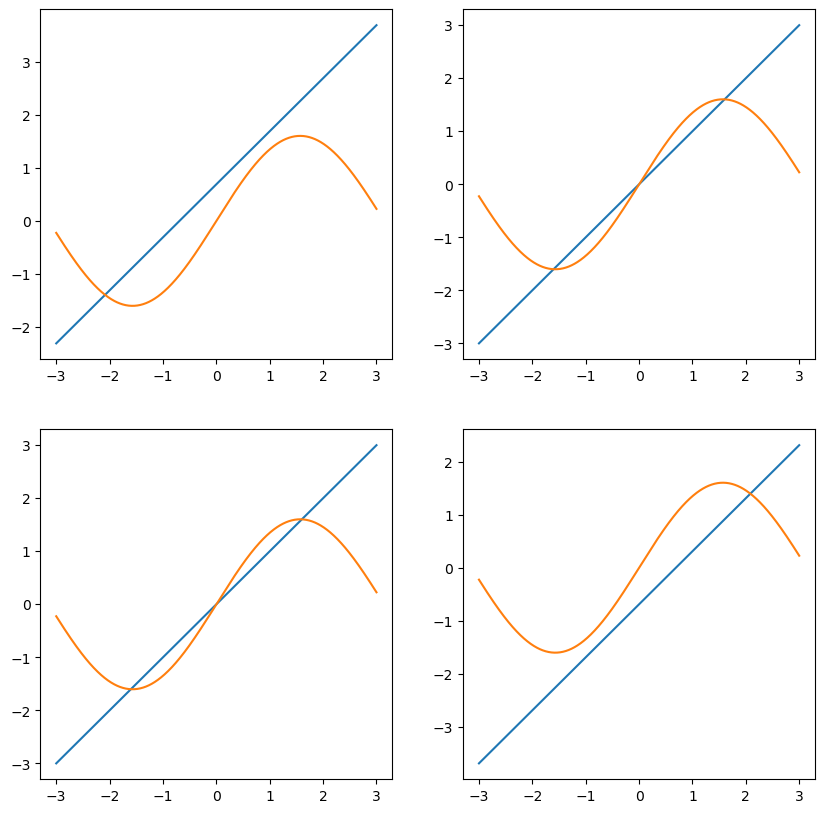

In [115]:
mu_value = 0.15

test_params = {
    'duration': 100,
    'phi_1x': 0.0, 'phi_2x': 0.0, 'phi_3x': 0.0,
    'mu_12': mu_value, 'mu_13': mu_value, 'mu_23': mu_value,
    'phi_1xdc': 0.8,'phi_2xdc': 0.0, 'phi_3xdc': 0.0,
    'name': 'conditional_tilt_xz'
}

draw_dUdp1_on_edges(test_params)

In [218]:
def dU_dw(beta, mu_12, mu_13, mu_23, phi_1x, phi_2x, phi_3x, phi_1dc, phi_2dc, phi_3c, w):
    xi_123 = 1 / (1 - mu_12**2 - mu_13**2 - mu_23**2 - 2 * mu_12 * mu_13 * mu_23)
    a = 1/np.sqrt(2) * xi_123 * (1 + mu_12 + mu_13 * mu_23) * (np.sqrt(2) * w - phi_1x - phi_2x)
    b = 1/np.sqrt(2) * xi_123 * (mu_12 + mu_23 + mu_13 * mu_23 + mu_12 * mu_13) * (phi_3c - phi_3x)
    c = -beta / np.sqrt(2) * np.sin(w/np.sqrt(2)) * (np.cos(phi_1dc/2) + np.cos(phi_2dc/2))
    return a + b + c

def dU_dv(beta, mu_12, mu_13, mu_23, phi_1x, phi_2x, phi_3x, phi_1dc, phi_2dc, phi_3c, v):
    xi_123 = 1 / (1 - mu_12**2 - mu_13**2 - mu_23**2 - 2 * mu_12 * mu_13 * mu_23)
    a = 1/np.sqrt(2) * xi_123 * (1 - mu_12 - mu_13 * mu_23) * (np.sqrt(2) * v + phi_1x - phi_2x)
    b = 1/np.sqrt(2) * xi_123 * (mu_23 - mu_13 + mu_12 * mu_13 - mu_12 * mu_23) * (phi_3c - phi_3x)
    c = -beta / np.sqrt(2) * np.sin(v/np.sqrt(2)) * (np.cos(phi_1dc/2) + np.cos(phi_2dc/2))
    return a + b + c

def dU_dp3_w(beta, mu_12, mu_13, mu_23, phi_1x, phi_2x, phi_3x, phi_1dc, phi_2dc, phi_3dc, phi_3c, w):
    xi_123 = 1 / (1 - mu_12**2 - mu_13**2 - mu_23**2 - 2 * mu_12 * mu_13 * mu_23)
    a = xi_123 * (phi_3c - phi_3x)
    b = xi_123 * (mu_13 + mu_12 * mu_23) * (w/np.sqrt(2) - phi_1x)
    c = xi_123 * (mu_23 + mu_12 * mu_13) * (w/np.sqrt(2) - phi_2x)
    d = -beta * np.sin(phi_3c) * np.cos(phi_3dc/2)
    return a + b + c + d

def dU_dp3_v(beta, mu_12, mu_13, mu_23, phi_1x, phi_2x, phi_3x, phi_1dc, phi_2dc, phi_3dc, phi_3c, v):
    xi_123 = 1 / (1 - mu_12**2 - mu_13**2 - mu_23**2 - 2 * mu_12 * mu_13 * mu_23)
    a = xi_123 * (phi_3c - phi_3x)
    b = xi_123 * (mu_13 + mu_12 * mu_23) * (-v/np.sqrt(2) - phi_1x)
    c = xi_123 * (mu_23 + mu_12 * mu_13) * (v/np.sqrt(2) - phi_2x)
    d = -beta * np.sin(phi_3c) * np.cos(phi_3dc/2)
    return a + b + c + d

In [303]:
def drawGraph(beta, mu_12, mu_13, mu_23, phi_1x, phi_2x, phi_3x, phi_1xdc, phi_2xdc, phi_3xdc, phi_3c, w_array):
    dU_dw_up = dU_dw(beta = beta, mu_12 = mu_12, mu_13 = mu_13, mu_23 = mu_23, phi_1x = phi_1x, phi_2x = phi_2x, phi_3x = phi_3x, 
         phi_1dc = phi_1xdc, phi_2dc = phi_2xdc, phi_3c = phi_3c, w = w_array)

    dU_dw_down = dU_dw(beta = beta, mu_12 = mu_12, mu_13 = mu_13, mu_23 = mu_23, phi_1x = phi_1x, phi_2x = phi_2x, phi_3x = phi_3x, 
             phi_1dc = phi_1xdc, phi_2dc = phi_2xdc, phi_3c = -phi_3c, w = w_array)

    dU_dv_up = dU_dv(beta = beta, mu_12 = mu_12, mu_13 = mu_13, mu_23 = mu_23, phi_1x = phi_1x, phi_2x = phi_2x, phi_3x = phi_3x, 
         phi_1dc = phi_1xdc, phi_2dc = phi_2xdc, phi_3c = phi_3c, v = w_array)

    dU_dv_down = dU_dv(beta = beta, mu_12 = mu_12, mu_13 = mu_13, mu_23 = mu_23, phi_1x = phi_1x, phi_2x = phi_2x, phi_3x = phi_3x, 
             phi_1dc = phi_1xdc, phi_2dc = phi_2xdc, phi_3c = -phi_3c, v = w_array)

    
    fig, ax = plt.subplots(1, 3, figsize = [12, 3])
    ax[0].plot(w_array, dU_dw_up, label = "w")
    ax[0].plot(w_array, dU_dv_up, label = "v")
    ax[0].hlines(y = 0, xmin = -4, xmax = 4, linestyle = "--", color = "red")
    ax[0].set_title("up plane")
    ax[0].legend()
    
    ax[1].plot(w_array, dU_dw_down, label = "w")
    ax[1].plot(w_array, dU_dv_down, label = "v")
    ax[1].hlines(y = 0, xmin = -4, xmax = 4, linestyle = "--", color = "red")
    ax[1].set_title("down plane")
    ax[1].legend()

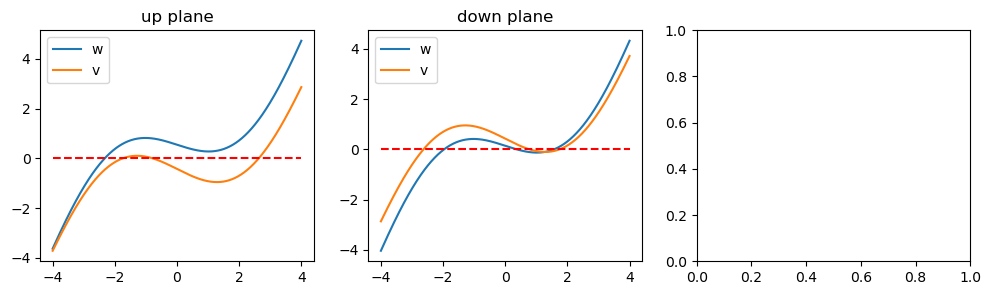

In [310]:
mu_12, mu_13, mu_23 = 0.1, 0.3, -0.0
xi_123 = 1 / (1 - mu_12**2 - mu_13**2 - mu_23**2 - 2 * mu_12 * mu_13 * mu_23)
w_array = np.linspace(-4, 4, 1000)
beta = 2.3
phi_3c = 2
phi_1xdc, phi_2xdc, phi_3xdc = [np.pi/2]*2 + [0]
phi_1x, phi_2x, phi_3x = -0.2, -0.2, 0.0
drawGraph(beta = beta, mu_12 = mu_12, mu_13 = mu_13, mu_23 = mu_23, phi_1x = phi_1x, phi_2x = phi_2x, phi_3x = phi_3x, 
         phi_1xdc = phi_1xdc, phi_2xdc = phi_2xdc, phi_3xdc = phi_3xdc, phi_3c = phi_3c, w_array = w_array)


In [624]:
def get_XYU(domain = [-4, 4], resolution = 50, detail_info = False, params = initial_parameter_dict):
    """
    To get the 2D data of the potential for contour plots
    """
    x_vec = np.linspace(domain[0], domain[1], resolution)
    phi_1xdc, phi_2xdc, phi_3xdc = params['phi_1xdc'], params['phi_2xdc'], params['phi_3xdc']
    X, Y = np.meshgrid(x_vec, x_vec)
    U_12 = coupled_fq_pot.potential(X, Y, 0, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_23 = coupled_fq_pot.potential(0, X, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    U_13 = coupled_fq_pot.potential(X, 0, Y, phi_1xdc, phi_2xdc, phi_3xdc, params = params.values())
    return X, Y, U_12, U_23, U_13

# bifurcation analysis

In [328]:
from scipy import optimize
import numpy as np
import imageio
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation, PillowWriter

In [396]:
guess_set = [(-2, -2, -2), (-2, 2, -2), (2, -2, -2), (2, 2, -2), (-2, -2, 2), (-2, 2, 2), (2, -2, 2), (2, 2, 2)]

In [397]:
def pot_function(circuit_params=circuit_params, detail_info = False, dimensional = False):
    beta_1 = circuit_params["beta_1"]
    beta_2 = circuit_params["beta_2"]
    beta_3 = circuit_params["beta_3"]
    gamma_1 = circuit_params["gamma_1"]
    gamma_2 = circuit_params["gamma_2"]
    gamma_3 = circuit_params["gamma_3"]
    d_beta_1 = circuit_params["d_beta_1"]
    d_beta_2 = circuit_params["d_beta_2"]
    d_beta_3 = circuit_params["d_beta_3"]
    _phi_1x = circuit_params["phi_1x"]
    _phi_2x = circuit_params["phi_2x"]
    _phi_3x = circuit_params["phi_3x"]
    _phi_1xdc = circuit_params["phi_1xdc"]
    _phi_2xdc = circuit_params["phi_2xdc"]
    _phi_3xdc = circuit_params["phi_3xdc"]
    _mu_12 = circuit_params["mu_12"]
    _mu_13 = circuit_params["mu_13"]
    _mu_23 = circuit_params["mu_23"]
    _phi_1dc = _phi_1xdc
    _phi_2dc = _phi_2xdc
    _phi_3dc = _phi_3xdc

    def Fcn(coord):
        _phi_1, _phi_2, _phi_3 = coord
        xi_123 = 1 / (1 - mu_12**2 - mu_13**2 - mu_23**2 + 2 * mu_12 * mu_13 * mu_23)

        u_11 = 1/2 * xi_123 * (_phi_1 - _phi_1x)**2
        u_12 = 1/2 * gamma_1 * (_phi_1dc - _phi_1xdc)**2
        u_13 = beta_1 * np.cos(_phi_1) * np.cos(_phi_1dc/2)
        u_14 = d_beta_1 * np.sin(_phi_1) * np.sin(_phi_1dc/2)
    
        u_21 = 1/2 * xi_123 * (_phi_2 - _phi_2x)**2
        u_22 = 1/2 * gamma_2 * (_phi_2dc - _phi_2xdc)**2
        u_23 = beta_2 * np.cos(_phi_2) * np.cos(_phi_2dc/2)
        u_24 = d_beta_2 * np.sin(_phi_2) * np.sin(_phi_2dc/2)
    
        u_31 = 1/2 * xi_123 * (_phi_3 - _phi_3x)**2
        u_32 = 1/2 * gamma_3 * (_phi_3dc - _phi_3xdc)**2
        u_33 = beta_3 * np.cos(_phi_3) * np.cos(_phi_3dc/2)
        u_34 = d_beta_3 * np.sin(_phi_3) * np.sin(_phi_3dc/2)

        u_4 = xi_123 * ((mu_12 + mu_13 * mu_23) * (_phi_1 - _phi_1x) * (_phi_2 - _phi_2x) + (mu_13 + mu_12 * mu_23) * (_phi_1 - _phi_1x) * (_phi_3 - _phi_3x) \
                        + (mu_23 + mu_12 * mu_13) * (_phi_2 - _phi_2x) * (_phi_3 - _phi_3x))

        U = (u_11 + u_12 + u_13 + u_14) + (u_21 + u_22 + u_23 + u_24) + (u_31 + u_32 + u_33 + u_34) + u_4
        
        return U

    return Fcn

def first_derivative_of_pot_function(circuit_params=circuit_params):
    beta_1 = circuit_params["beta_1"]
    beta_2 = circuit_params["beta_2"]
    beta_3 = circuit_params["beta_3"]
    gamma_1 = circuit_params["gamma_1"]
    gamma_2 = circuit_params["gamma_2"]
    gamma_3 = circuit_params["gamma_3"]
    d_beta_1 = circuit_params["d_beta_1"]
    d_beta_2 = circuit_params["d_beta_2"]
    d_beta_3 = circuit_params["d_beta_3"]
    phi_1x = circuit_params["phi_1x"]
    phi_2x = circuit_params["phi_2x"]
    phi_3x = circuit_params["phi_3x"]
    phi_1xdc = circuit_params["phi_1xdc"]
    phi_2xdc = circuit_params["phi_2xdc"]
    phi_3xdc = circuit_params["phi_3xdc"]
    mu_12 = circuit_params["mu_12"]
    mu_13 = circuit_params["mu_13"]
    mu_23 = circuit_params["mu_23"]
    phi_1dc = phi_1xdc
    phi_2dc = phi_2xdc
    phi_3dc = phi_3xdc
    xi_123 = 1 / (1 - mu_12**2 - mu_13**2 - mu_23**2 + 2 * mu_12 * mu_13 * mu_23)
    
    def Fcn(coord):
        phi_1, phi_2, phi_3 = coord
        U_dp1 =  xi_123 * (phi_1 - phi_1x) + xi_123 * (mu_12 + mu_13 * mu_23) * (phi_2 - phi_2x) + xi_123 * (mu_13 + mu_12 * mu_23) * (phi_3 - phi_3x) - beta_1 * np.sin(phi_1) * np.cos(phi_1dc/2)+  d_beta_1 * np.cos(phi_1) * np.sin(phi_1dc/2)

        U_dp2 = xi_123 * (phi_2 - phi_2x) + xi_123 * (mu_12 + mu_13 * mu_23) * (phi_1 - phi_1x) + xi_123 * (mu_23 + mu_12 * mu_13) * (phi_3 - phi_3x) - beta_2 * np.sin(phi_2) * np.cos(phi_2dc/2)+  d_beta_2 * np.cos(phi_2) * np.sin(phi_2dc/2)
    
        U_dp3 = xi_123 * (phi_3 - phi_3x) + xi_123 * (mu_13 + mu_12 * mu_23) * (phi_1 - phi_1x) + xi_123 * (mu_23 + mu_12 * mu_13) * (phi_2 - phi_2x) - beta_3 * np.sin(phi_3) * np.cos(phi_3dc/2)+  d_beta_3 * np.cos(phi_3) * np.sin(phi_3dc/2)
    
        U_dp1dc = gamma_1 * (phi_1dc - phi_1xdc) - 1/2 * beta_1 * np.cos(phi_1) * np.sin(phi_1dc / 2) + 1/2 * d_beta_1 * np.sin(phi_1) * np.cos(phi_1dc/2)
    
        U_dp2dc = gamma_2 * (phi_2dc - phi_2xdc) - 1/2 * beta_2 * np.cos(phi_2) * np.sin(phi_2dc / 2) + 1/2 * d_beta_2 * np.sin(phi_2) * np.cos(phi_2dc/2)
    
        U_dp3dc = gamma_3 * (phi_3dc - phi_3xdc) - 1/2 * beta_3 * np.cos(phi_3) * np.sin(phi_3dc / 2) + 1/2 * d_beta_3 * np.sin(phi_3) * np.cos(phi_3dc/2)

        return np.array([
            U_dp1, U_dp2, U_dp3
        ])
    return Fcn

def find_all_minimum_points_for_all_potential(circuit_params, guess = [(0, 0, 0)]):
    """"
    To find all the maximum points, of the potential function
    """
    solution_set = [optimize.fmin(pot_function(circuit_params), _g, disp=False) for _g in guess]
    # energy_set = [coupled_flux_qubit_non_linear_approx_pot(sol[0], sol[1], _phi_1dcx, _phi_2dcx, _params_at_t) for sol in solution_set]
    return {"coord": solution_set}

def find_all_critical_points_for_all_potential(circuit_params, guess = [(0, 0)]):
    """"
    To find all the critical points, including the saddle, minimum and maximum points, of the potential function
    """
    solution_set = [optimize.fsolve(first_derivative_of_pot_function(circuit_params), _g) for _g in guess, xtol=1e-06, maxfev=500]
    # energy_set = [coupled_flux_qubit_non_linear_approx_pot(sol[0], sol[1], _phi_1dcx, _phi_2dcx, _params_at_t) for sol in solution_set]
    return {"coord": solution_set}

In [398]:
PHI_0 = 2.067833848 * 1e-15
k_B = 1.38e-23
T = 0.5
k_BT = k_B * T

C_factor = 1
L_factor = 1
R_factor = 20
I_m_factor = 0

U0_1, U0_2, U0_3 = 1, 1, 1

I_p_1, I_p_2, I_p_3 = 5e-6, 5e-6 , 5e-6  # Amp
I_m_1, I_m_2, I_m_3 = 7e-9 * I_m_factor, 7e-9 * I_m_factor, 7e-9 * I_m_factor              # Amp
R_1, R_2, R_3 = 1 * R_factor, 1 * R_factor, 1 * R_factor           # ohm
C_1, C_2, C_3 = 500e-15 * C_factor, 500e-15 * C_factor, 500e-15 * C_factor                 # F
L_1, L_2, L_3 = 140e-12 * L_factor, 140e-12 * L_factor, 140e-12 * L_factor                 # H  

x_c = PHI_0 / (2 * np.pi)
t_c = np.sqrt(L_1 * C_1)
v_c = x_c / t_c
gamma_1, gamma_2, gamma_3 = 20, 20, 20


beta_1 = 2 * np.pi * L_1 * I_p_1 / PHI_0; 
beta_2 = 2 * np.pi * L_2 * I_p_2 / PHI_0;
beta_3 = 2 * np.pi * L_3 * I_p_3 / PHI_0;

beta_1 = 2.3
beta_2 = 2.3
beta_3 = 2.3

d_beta_1 = 2 * np.pi * L_1 * I_m_1 / PHI_0; 
d_beta_2 = 2 * np.pi * L_2 * I_m_2 / PHI_0;
d_beta_3 = 2 * np.pi * L_3 * I_m_3 / PHI_0;

In [619]:
circuit_params = {
    "U0_1": U0_1, "U0_2": U0_2, "U0_3": U0_2, "gamma_1": gamma_1, "gamma_2": gamma_2, "gamma_3": gamma_3, 
    "beta_1": beta_1, "beta_2": beta_2, "beta_3": beta_3, "d_beta_1": d_beta_1, "d_beta_2": d_beta_2, "d_beta_3": d_beta_3, 
    "phi_1x": 0, "phi_2x": 0, "phi_3x": 0.0, "phi_1xdc": np.pi * 0.4 , "phi_2xdc": np.pi * 0.6, "phi_3xdc": 0, "mu_12":0, "mu_13": 0.2, "mu_23": 0.1
}

In [620]:
def find_all_critical_points_for_all_potential(circuit_params, guess = [(0, 0)]):
    """"
    To find all the critical points, including the saddle, minimum and maximum points, of the potential function
    """
    solution_set = [optimize.fsolve(first_derivative_of_pot_function(circuit_params), _g, xtol=1e-05, maxfev=5000) for _g in guess]
    # energy_set = [coupled_flux_qubit_non_linear_approx_pot(sol[0], sol[1], _phi_1dcx, _phi_2dcx, _params_at_t) for sol in solution_set]
    return {"coord": solution_set}

In [621]:
guess_set = [(-2, -2, -2), (-2, 2, -2), (2, -2, -2), (1, 1, -2), (-2, -2, 2), (-2, 2, 2), (2, -2, 2), (2, 2, 2)]

000 [-1.353486   -0.68774288 -1.78904868]
001 [-1.38127761  1.50122903 -1.92399199]
010 [ 2.02990864 -0.68369058 -2.15640674]
011 [ 2.0160672   1.46126977 -2.24975988]
100 [-2.01606721 -1.46127005  2.24975998]
101 [-2.02990864  0.68369058  2.15640674]
110 [ 1.38127761 -1.50122903  1.92399199]
111 [1.353486   0.6877429  1.78904868]


/var/folders/86/1b8x7lgn53d2cmkkd0c8wckc0000gp/T/ipykernel_73982/2193432780.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  solution_set = [optimize.fsolve(first_derivative_of_pot_function(circuit_params), _g, xtol=1e-05, maxfev=5000) for _g in guess]


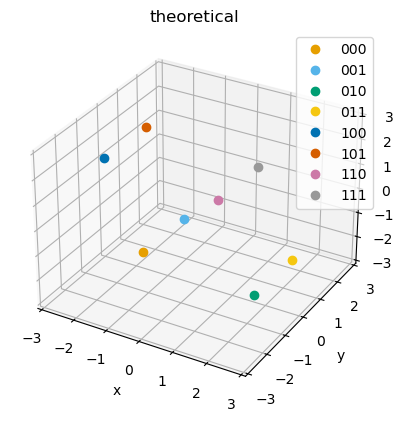

In [622]:
critical_points = find_all_critical_points_for_all_potential(circuit_params, guess=guess_set)

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
particle_label = ["000", "001", "010", "011", "100", "101", "110", "111"]
particle_color = ["#E69F00",  "#56B4E9",  "#009E73",  "#F5C710",  "#0072B2",  "#D55E00",  "#CC79A7", "#999999",  "#000000"]
for key, point, color in  zip(particle_label, critical_points['coord'], particle_color):
    print(key, point)
    graph = ax.plot(point[0], point[1], point[2], c = color, label = key, linestyle="", marker="o")
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("theoretical")
ax.legend()
plt.show()

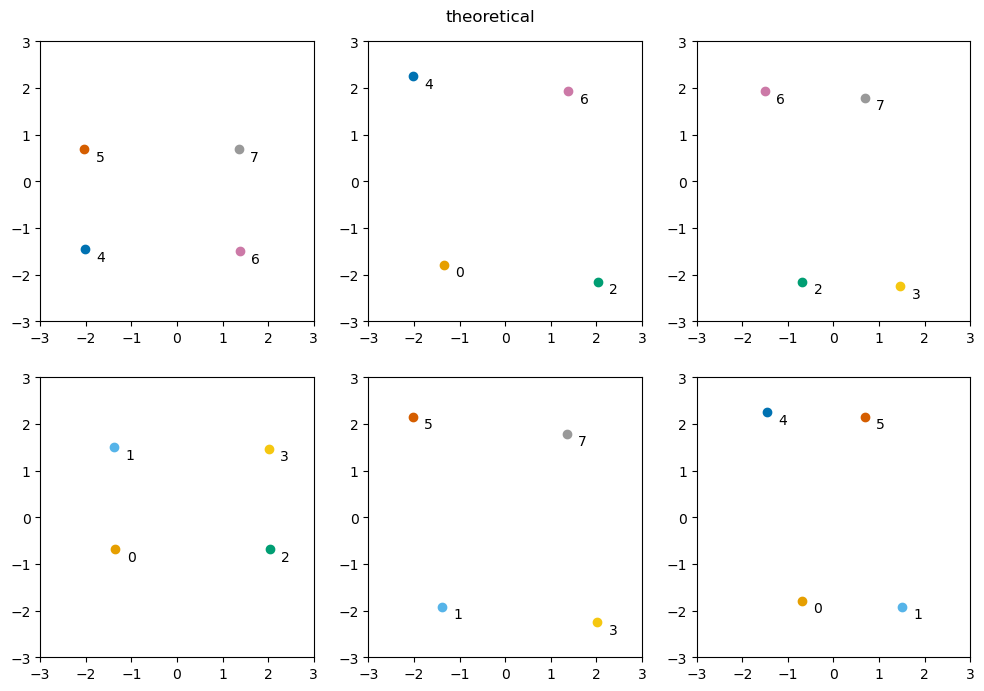

In [623]:
fig, ax = plt.subplots(2, 3, figsize=[12, 8])
ax_flatten = ax.flatten()
fig.suptitle("theoretical", y = 0.92)
xy_top_plane = [4, 5, 6, 7]
xy_bottom_plane = [0, 1, 2, 3]
xz_front_plane = [0, 2, 4, 6]
xz_back_plane = [1, 3, 5, 7]
yz_right_plane = [2, 3, 6, 7]
yz_left_plane = [0, 1, 4, 5]

for x in xy_top_plane:
    ax_flatten[0].plot(critical_points['coord'][x][0], critical_points['coord'][x][1], c = particle_color[x],marker="o")
    ax_flatten[0].text(critical_points['coord'][x][0] + 0.25, critical_points['coord'][x][1] - 0.25, x)
    ax_flatten[0].set_xlim(-3, 3)
    ax_flatten[0].set_ylim(-3, 3)

for x in xy_bottom_plane:
    ax_flatten[3].plot(critical_points['coord'][x][0], critical_points['coord'][x][1], c = particle_color[x],marker="o")
    ax_flatten[3].text(critical_points['coord'][x][0] + 0.25, critical_points['coord'][x][1] - 0.25, x)
    ax_flatten[3].set_xlim(-3, 3)
    ax_flatten[3].set_ylim(-3, 3)

for x in xz_front_plane:
    ax_flatten[1].plot(critical_points['coord'][x][0], critical_points['coord'][x][2], c = particle_color[x],marker="o")
    ax_flatten[1].text(critical_points['coord'][x][0] + 0.25, critical_points['coord'][x][2] - 0.25, x)
    ax_flatten[1].set_xlim(-3, 3)
    ax_flatten[1].set_ylim(-3, 3)

for x in xz_back_plane:
    ax_flatten[4].plot(critical_points['coord'][x][0], critical_points['coord'][x][2], c = particle_color[x],marker="o")
    ax_flatten[4].text(critical_points['coord'][x][0] + 0.25, critical_points['coord'][x][2] - 0.25, x)
    ax_flatten[4].set_xlim(-3, 3)
    ax_flatten[4].set_ylim(-3, 3)

for x in yz_right_plane:
    ax_flatten[2].plot(critical_points['coord'][x][1], critical_points['coord'][x][2], c = particle_color[x],marker="o")
    ax_flatten[2].text(critical_points['coord'][x][1] + 0.25, critical_points['coord'][x][2] - 0.25, x)
    ax_flatten[2].set_xlim(-3, 3)
    ax_flatten[2].set_ylim(-3, 3)

for x in yz_left_plane:
    ax_flatten[5].plot(critical_points['coord'][x][1], critical_points['coord'][x][2], c = particle_color[x],marker="o")
    ax_flatten[5].text(critical_points['coord'][x][1] + 0.25, critical_points['coord'][x][2] - 0.25, x)
    ax_flatten[5].set_xlim(-3, 3)
    ax_flatten[5].set_ylim(-3, 3)

